# data loading

In [1]:
%load_ext autoreload
%autoreload 2

In [141]:
%load_ext jupyternotify
%autonotify -a 30

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
import datetime, math
from tqdm.notebook import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as accuracy

In [4]:
torch.manual_seed(1)

In [5]:
from models.utils import *

In [6]:
names = ['IMOEX', 'ICE.BRN', 'FUTSEE-100', 'comex.GC', 'SANDP-500']
dates = ['111101_131031', '131101_151031', '151101_171031', '171101_191031', '191101_211031'] #
data_5m = load_data(names, dates, path='data/')
data_5m = data_5m.loc[data_5m.date != '2012-12-26 19:40:00', :]

In [7]:
idx = ['imoex', 'brent', 'ftse', 'snp', 'gold']
data_5m = prepare_data(data_5m, idx)
data_day = make_daily_data(data_5m, idx)
data_5m = data_5m[2:].set_index('date')

In [8]:
data_usd = load_currency('USD')
data_eur = load_currency('EUR')
data_yield = load_yield('data/')

In [9]:
data_day = data_day.join(data_usd, how='left').join(data_eur, how='left').join(data_yield, how='left').dropna()

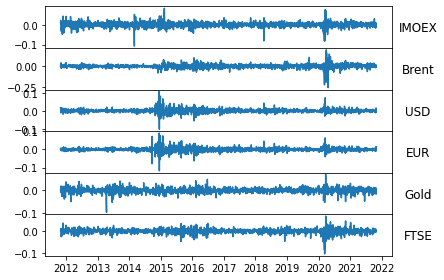

In [10]:
fig = plt.figure()
gs = fig.add_gridspec(6, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
axs[0].plot(data_day['return_imoex'])
axs[0].set_title('IMOEX', x=1.075, y=0.25) # , rotation='vertical'
axs[1].plot(data_day['return_brent'])
axs[1].set_title('Brent', x=1.075, y=0.25)
axs[2].plot(data_day['return_usd'])
axs[2].set_title('USD', x=1.075, y=0.25)
axs[3].plot(data_day['return_eur'])
axs[3].set_title('EUR', x=1.075, y=0.25)
axs[4].plot(data_day['return_gold'])
axs[4].set_title('Gold', x=1.075, y=0.25)
axs[5].plot(data_day['return_ftse'])
axs[5].set_title('FTSE', x=1.075, y=0.25)
fig.tight_layout()
# fig.savefig('series.pdf', format='pdf', bbox_inches='tight')

# lstm model

In [178]:
config = {
    'seq_length': 5,
    'steps': 1,
    'batch_size': 256,
    'task': 'regression',
    'target': 'return_imoex',
    'output_size': 1,
    'input_size': 4,
    'idx': 'imoex',
    # 'idx': 'imoex,usd,eur,brent,gold,ftse,snp',
    # 'var': 'return',
    'var': 'return,volume,volatility,spread',
    # 'add': 'dayofweek',
    'add': ''
}

## dataloaders

In [12]:
data = take_vars(
    data_day, 
    idx=config['idx'].split(','), 
    var=config['var'].split(','), 
    add=config['add'].split(',')
)

In [13]:
norm_stats = calculate_norm_stats(data, train_size=0.8, exclude=['time','dayofweek'], only_std=['return_imoex'], robust=True)
full_dataset = TickerDataset(data, y='return_imoex', seq_length=config['seq_length'], norm_stats=norm_stats, steps=config['steps'], task=config['task'])
train_dataset, val_dataset, test_dataset = sequential_split(full_dataset, splits=[0.8, 0.1, 0.1])
config['input_size'] = full_dataset.data.shape[1]

In [14]:
# from sklearn.model_selection import TimeSeriesSplit
# split = TimeSeriesSplit(n_splits=5)

In [15]:
# gen = split.split(np.arange(len(data)))

In [16]:
# train_idx, val_idx = next(gen)

In [17]:
# len(train_idx), len(val_idx)

In [18]:
full_loader = DataLoader(full_dataset, batch_size=config['batch_size'], shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [19]:
# dc = DataCollection(data_day, config=config)
# full_dataset, train_dataset, val_dataset, test_dataset = dc.datasets
# full_loader, train_loader, val_loader, test_loader = dc.dataloaders

## lightning

In [179]:
import copy
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [180]:
import warnings
warnings.filterwarnings('ignore', '.*does not have many workers.*')

In [181]:
from models import *

In [182]:
data = take_vars(
    data_day, 
    idx=config['idx'].split(','), 
    var=config['var'].split(','), 
    add=config['add'].split(',')
)

In [183]:
pl_data = MyDataModule(
    data, 
    target=config['target'], 
    seq_length=config['seq_length'], 
    batch_size=config['batch_size'],
    num_workers=0)
pl_data.setup()

In [206]:
model = VanillaLSTM(
    input_size=len(config['var'].split(',')),
    output_size=config['output_size'],
    seq_length=config['seq_length'],
    steps=config['steps'],
    
    lstm_layers=1,
    lstm_hidden_size=8, # try 8
    bidirectional=False,
    
    fc_layers=None,
    fc_hidden_size=32,
    dropout=0,
)

In [207]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

561

In [208]:
pl_model = MyLightningModule(model, **dict(lr=0.001, wd=0.001, gamma=1))

In [209]:
checkpointer = ModelCheckpoint(save_top_k=1, save_last=True, monitor='valid_loss')
logger = CSVLogger(save_dir='')
printer = PrintMetricsCallback(metrics=['train_loss_epoch', 'valid_loss_epoch'])
# stopper = EarlyStopping(monitor='valid_loss', mode='min', check_on_train_epoch_end=True, patience=1000, verbose=True)

In [210]:
v = max([int(i.split('_')[-1]) for i in os.listdir('lightning_logs')]) + 1

In [211]:
trainer = pl.Trainer(
    log_every_n_steps=1, 
    logger=logger, 
    callbacks=[printer, checkpointer], 
    max_epochs=500, 
    # max_epochs=1500, 
    # resume_from_checkpoint=f'lightning_logs/version_{v}/checkpoints/last.ckpt' 
)
trainer.fit(pl_model, pl_data) # train_loader, val_loader

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type        | Params
------------------------------------------
0 | model     | VanillaLSTM | 561   
1 | criterion | MSELoss     | 0     
------------------------------------------
561       Trainable params
0         Non-trainable params
561       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

epoch: 0
valid_loss_epoch: 4.233429431915283
--------------------------------------------------------------------------------


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch: 1
valid_loss_epoch: 4.220679759979248
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 2
train_loss_epoch: 2.1943304538726807
valid_loss_epoch: 4.215613842010498
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 3
train_loss_epoch: 2.191309690475464
valid_loss_epoch: 4.212620258331299
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 4
train_loss_epoch: 2.1897075176239014
valid_loss_epoch: 4.208066463470459
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 5
train_loss_epoch: 2.1880733966827393
valid_loss_epoch: 4.203685760498047
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 6
train_loss_epoch: 2.186694622039795
valid_loss_epoch: 4.200616836547852
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 7
train_loss_epoch: 2.1853561401367188
valid_loss_epoch: 4.197840213775635
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 8
train_loss_epoch: 2.1842291355133057
valid_loss_epoch: 4.195216178894043
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 9
train_loss_epoch: 2.183128595352173
valid_loss_epoch: 4.1951470375061035
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 10
train_loss_epoch: 2.1817209720611572
valid_loss_epoch: 4.195501327514648
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 11
train_loss_epoch: 2.180896043777466
valid_loss_epoch: 4.1952009201049805
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 12
train_loss_epoch: 2.179633855819702
valid_loss_epoch: 4.192804336547852
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 13
train_loss_epoch: 2.179015874862671
valid_loss_epoch: 4.192291259765625
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 14
train_loss_epoch: 2.177809000015259
valid_loss_epoch: 4.191855430603027
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 15
train_loss_epoch: 2.1771562099456787
valid_loss_epoch: 4.191990852355957
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 16
train_loss_epoch: 2.1762356758117676
valid_loss_epoch: 4.192878246307373
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 17
train_loss_epoch: 2.175513744354248
valid_loss_epoch: 4.193450927734375
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 18
train_loss_epoch: 2.1746084690093994
valid_loss_epoch: 4.192936420440674
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 19
train_loss_epoch: 2.1738626956939697
valid_loss_epoch: 4.192379474639893
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 20
train_loss_epoch: 2.1729896068573
valid_loss_epoch: 4.192542552947998
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 21
train_loss_epoch: 2.172086238861084
valid_loss_epoch: 4.191558837890625
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 22
train_loss_epoch: 2.1713948249816895
valid_loss_epoch: 4.190850734710693
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 23
train_loss_epoch: 2.170753002166748
valid_loss_epoch: 4.191145896911621
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 24
train_loss_epoch: 2.1699252128601074
valid_loss_epoch: 4.191747188568115
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 25
train_loss_epoch: 2.1693503856658936
valid_loss_epoch: 4.191804885864258
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 26
train_loss_epoch: 2.168515205383301
valid_loss_epoch: 4.193176746368408
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 27
train_loss_epoch: 2.1677637100219727
valid_loss_epoch: 4.193649768829346
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 28
train_loss_epoch: 2.1667089462280273
valid_loss_epoch: 4.194807529449463
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 29
train_loss_epoch: 2.165987730026245
valid_loss_epoch: 4.1949076652526855
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 30
train_loss_epoch: 2.1652331352233887
valid_loss_epoch: 4.196078777313232
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 31
train_loss_epoch: 2.1644551753997803
valid_loss_epoch: 4.196807861328125
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 32
train_loss_epoch: 2.163731575012207
valid_loss_epoch: 4.198041915893555
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 33
train_loss_epoch: 2.1631102561950684
valid_loss_epoch: 4.199840545654297
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 34
train_loss_epoch: 2.1621506214141846
valid_loss_epoch: 4.201830863952637
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 35
train_loss_epoch: 2.1612584590911865
valid_loss_epoch: 4.205085277557373
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 36
train_loss_epoch: 2.1607465744018555
valid_loss_epoch: 4.207102298736572
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 37
train_loss_epoch: 2.160008430480957
valid_loss_epoch: 4.208033084869385
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 38
train_loss_epoch: 2.15887451171875
valid_loss_epoch: 4.208507537841797
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 39
train_loss_epoch: 2.158278703689575
valid_loss_epoch: 4.209145545959473
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 40
train_loss_epoch: 2.157526731491089
valid_loss_epoch: 4.209457874298096
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 41
train_loss_epoch: 2.1566567420959473
valid_loss_epoch: 4.211175918579102
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 42
train_loss_epoch: 2.155698299407959
valid_loss_epoch: 4.212918758392334
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 43
train_loss_epoch: 2.15510892868042
valid_loss_epoch: 4.215625762939453
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 44
train_loss_epoch: 2.1540091037750244
valid_loss_epoch: 4.219191551208496
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 45
train_loss_epoch: 2.1532702445983887
valid_loss_epoch: 4.223239898681641
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 46
train_loss_epoch: 2.152249574661255
valid_loss_epoch: 4.228341579437256
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 47
train_loss_epoch: 2.151503324508667
valid_loss_epoch: 4.230165004730225
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 48
train_loss_epoch: 2.150245428085327
valid_loss_epoch: 4.231224536895752
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 49
train_loss_epoch: 2.149313449859619
valid_loss_epoch: 4.2340922355651855
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 50
train_loss_epoch: 2.1482958793640137
valid_loss_epoch: 4.2368693351745605
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 51
train_loss_epoch: 2.1472527980804443
valid_loss_epoch: 4.238584995269775
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 52
train_loss_epoch: 2.146371603012085
valid_loss_epoch: 4.2395710945129395
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 53
train_loss_epoch: 2.1453356742858887
valid_loss_epoch: 4.242349624633789
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 54
train_loss_epoch: 2.1438629627227783
valid_loss_epoch: 4.243863582611084
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 55
train_loss_epoch: 2.143026113510132
valid_loss_epoch: 4.247479438781738
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 56
train_loss_epoch: 2.1416378021240234
valid_loss_epoch: 4.251361846923828
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 57
train_loss_epoch: 2.1405715942382812
valid_loss_epoch: 4.256351947784424
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 58
train_loss_epoch: 2.1391775608062744
valid_loss_epoch: 4.262078285217285
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 59
train_loss_epoch: 2.1376194953918457
valid_loss_epoch: 4.265810012817383
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 60
train_loss_epoch: 2.1361873149871826
valid_loss_epoch: 4.26993989944458
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 61
train_loss_epoch: 2.1353001594543457
valid_loss_epoch: 4.272696495056152
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 62
train_loss_epoch: 2.1341466903686523
valid_loss_epoch: 4.276763916015625
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 63
train_loss_epoch: 2.1329548358917236
valid_loss_epoch: 4.281285762786865
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 64
train_loss_epoch: 2.131558418273926
valid_loss_epoch: 4.2897210121154785
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 65
train_loss_epoch: 2.130429744720459
valid_loss_epoch: 4.295971870422363
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 66
train_loss_epoch: 2.1289267539978027
valid_loss_epoch: 4.300178050994873
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 67
train_loss_epoch: 2.127776861190796
valid_loss_epoch: 4.303363800048828
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 68
train_loss_epoch: 2.126645088195801
valid_loss_epoch: 4.305296897888184
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 69
train_loss_epoch: 2.12520432472229
valid_loss_epoch: 4.310962677001953
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 70
train_loss_epoch: 2.124330520629883
valid_loss_epoch: 4.313385009765625
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 71
train_loss_epoch: 2.123251438140869
valid_loss_epoch: 4.318836212158203
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 72
train_loss_epoch: 2.1221256256103516
valid_loss_epoch: 4.320518493652344
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 73
train_loss_epoch: 2.120654344558716
valid_loss_epoch: 4.323864936828613
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 74
train_loss_epoch: 2.119462728500366
valid_loss_epoch: 4.326972961425781
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 75
train_loss_epoch: 2.1182515621185303
valid_loss_epoch: 4.326905250549316
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 76
train_loss_epoch: 2.1170122623443604
valid_loss_epoch: 4.325905799865723
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 77
train_loss_epoch: 2.115842819213867
valid_loss_epoch: 4.328376770019531
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 78
train_loss_epoch: 2.114424467086792
valid_loss_epoch: 4.331333160400391
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 79
train_loss_epoch: 2.11368989944458
valid_loss_epoch: 4.3401265144348145
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 80
train_loss_epoch: 2.1126840114593506
valid_loss_epoch: 4.346085548400879
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 81
train_loss_epoch: 2.1111080646514893
valid_loss_epoch: 4.34743070602417
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 82
train_loss_epoch: 2.1096086502075195
valid_loss_epoch: 4.35629415512085
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 83
train_loss_epoch: 2.1087958812713623
valid_loss_epoch: 4.357889652252197
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 84
train_loss_epoch: 2.1073906421661377
valid_loss_epoch: 4.357577323913574
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 85
train_loss_epoch: 2.106740713119507
valid_loss_epoch: 4.358711242675781
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 86
train_loss_epoch: 2.1050069332122803
valid_loss_epoch: 4.359543800354004
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 87
train_loss_epoch: 2.1033103466033936
valid_loss_epoch: 4.363236904144287
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 88
train_loss_epoch: 2.10186505317688
valid_loss_epoch: 4.366943359375
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 89
train_loss_epoch: 2.100869655609131
valid_loss_epoch: 4.371739387512207
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 90
train_loss_epoch: 2.0995044708251953
valid_loss_epoch: 4.367982864379883
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 91
train_loss_epoch: 2.097853899002075
valid_loss_epoch: 4.367430210113525
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 92
train_loss_epoch: 2.096914052963257
valid_loss_epoch: 4.371901988983154
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 93
train_loss_epoch: 2.0956430435180664
valid_loss_epoch: 4.376333713531494
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 94
train_loss_epoch: 2.0944697856903076
valid_loss_epoch: 4.382292747497559
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 95
train_loss_epoch: 2.093541145324707
valid_loss_epoch: 4.385592937469482
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 96
train_loss_epoch: 2.0921239852905273
valid_loss_epoch: 4.387845516204834
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 97
train_loss_epoch: 2.0914812088012695
valid_loss_epoch: 4.388278961181641
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 98
train_loss_epoch: 2.0898170471191406
valid_loss_epoch: 4.389673709869385
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 99
train_loss_epoch: 2.0882456302642822
valid_loss_epoch: 4.393087387084961
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 100
train_loss_epoch: 2.086972713470459
valid_loss_epoch: 4.393580913543701
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 101
train_loss_epoch: 2.085935115814209
valid_loss_epoch: 4.397642612457275
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 102
train_loss_epoch: 2.0853662490844727
valid_loss_epoch: 4.399456977844238
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 103
train_loss_epoch: 2.083958625793457
valid_loss_epoch: 4.400788307189941
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 104
train_loss_epoch: 2.0827696323394775
valid_loss_epoch: 4.405632972717285
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 105
train_loss_epoch: 2.08205246925354
valid_loss_epoch: 4.408303737640381
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 106
train_loss_epoch: 2.080294370651245
valid_loss_epoch: 4.410979747772217
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 107
train_loss_epoch: 2.078833818435669
valid_loss_epoch: 4.414851665496826
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 108
train_loss_epoch: 2.0776450634002686
valid_loss_epoch: 4.4188971519470215
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 109
train_loss_epoch: 2.077641725540161
valid_loss_epoch: 4.421850681304932
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 110
train_loss_epoch: 2.075091600418091
valid_loss_epoch: 4.4318084716796875
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 111
train_loss_epoch: 2.074303388595581
valid_loss_epoch: 4.438035011291504
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 112
train_loss_epoch: 2.07326602935791
valid_loss_epoch: 4.437769412994385
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 113
train_loss_epoch: 2.0712361335754395
valid_loss_epoch: 4.4340009689331055
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 114
train_loss_epoch: 2.0708515644073486
valid_loss_epoch: 4.440732479095459
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 115
train_loss_epoch: 2.0695977210998535
valid_loss_epoch: 4.445195198059082
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 116
train_loss_epoch: 2.0676021575927734
valid_loss_epoch: 4.448894023895264
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 117
train_loss_epoch: 2.0664710998535156
valid_loss_epoch: 4.450396537780762
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 118
train_loss_epoch: 2.0653905868530273
valid_loss_epoch: 4.448604106903076
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 119
train_loss_epoch: 2.064333438873291
valid_loss_epoch: 4.441853046417236
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 120
train_loss_epoch: 2.0629754066467285
valid_loss_epoch: 4.4403300285339355
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 121
train_loss_epoch: 2.0621843338012695
valid_loss_epoch: 4.446019649505615
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 122
train_loss_epoch: 2.0605602264404297
valid_loss_epoch: 4.451459884643555
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 123
train_loss_epoch: 2.0588436126708984
valid_loss_epoch: 4.462612628936768
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 124
train_loss_epoch: 2.057922840118408
valid_loss_epoch: 4.471471309661865
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 125
train_loss_epoch: 2.0573105812072754
valid_loss_epoch: 4.470394611358643
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 126
train_loss_epoch: 2.0561373233795166
valid_loss_epoch: 4.476350784301758
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 127
train_loss_epoch: 2.0544426441192627
valid_loss_epoch: 4.486894130706787
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 128
train_loss_epoch: 2.0533668994903564
valid_loss_epoch: 4.484750747680664
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 129
train_loss_epoch: 2.0519230365753174
valid_loss_epoch: 4.489442825317383
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 130
train_loss_epoch: 2.0505189895629883
valid_loss_epoch: 4.4865241050720215
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 131
train_loss_epoch: 2.0490882396698
valid_loss_epoch: 4.4876604080200195
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 132
train_loss_epoch: 2.0480868816375732
valid_loss_epoch: 4.489990234375
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 133
train_loss_epoch: 2.046969175338745
valid_loss_epoch: 4.498968601226807
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 134
train_loss_epoch: 2.0453834533691406
valid_loss_epoch: 4.507382869720459
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 135
train_loss_epoch: 2.0439963340759277
valid_loss_epoch: 4.511208534240723
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 136
train_loss_epoch: 2.043027639389038
valid_loss_epoch: 4.5152587890625
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 137
train_loss_epoch: 2.0419764518737793
valid_loss_epoch: 4.516681671142578
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 138
train_loss_epoch: 2.0407466888427734
valid_loss_epoch: 4.5201802253723145
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 139
train_loss_epoch: 2.039670944213867
valid_loss_epoch: 4.518988132476807
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 140
train_loss_epoch: 2.038928508758545
valid_loss_epoch: 4.522718906402588
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 141
train_loss_epoch: 2.0371952056884766
valid_loss_epoch: 4.530178546905518
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 142
train_loss_epoch: 2.0361108779907227
valid_loss_epoch: 4.528667449951172
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 143
train_loss_epoch: 2.034886121749878
valid_loss_epoch: 4.5342559814453125
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 144
train_loss_epoch: 2.0332436561584473
valid_loss_epoch: 4.538994789123535
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 145
train_loss_epoch: 2.0322482585906982
valid_loss_epoch: 4.546712398529053
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 146
train_loss_epoch: 2.031489610671997
valid_loss_epoch: 4.5527520179748535
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 147
train_loss_epoch: 2.030017614364624
valid_loss_epoch: 4.5688066482543945
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 148
train_loss_epoch: 2.028500556945801
valid_loss_epoch: 4.567676067352295
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 149
train_loss_epoch: 2.0274510383605957
valid_loss_epoch: 4.565155982971191
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 150
train_loss_epoch: 2.0263888835906982
valid_loss_epoch: 4.571727275848389
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 151
train_loss_epoch: 2.025782823562622
valid_loss_epoch: 4.567977428436279
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 152
train_loss_epoch: 2.0242156982421875
valid_loss_epoch: 4.573933124542236
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 153
train_loss_epoch: 2.022414445877075
valid_loss_epoch: 4.585841655731201
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 154
train_loss_epoch: 2.0217506885528564
valid_loss_epoch: 4.581302642822266
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 155
train_loss_epoch: 2.0198886394500732
valid_loss_epoch: 4.589339256286621
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 156
train_loss_epoch: 2.0188207626342773
valid_loss_epoch: 4.591384410858154
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 157
train_loss_epoch: 2.018002986907959
valid_loss_epoch: 4.595316410064697
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 158
train_loss_epoch: 2.016674518585205
valid_loss_epoch: 4.598682880401611
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 159
train_loss_epoch: 2.0150692462921143
valid_loss_epoch: 4.5973591804504395
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 160
train_loss_epoch: 2.014432668685913
valid_loss_epoch: 4.595927715301514
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 161
train_loss_epoch: 2.0135412216186523
valid_loss_epoch: 4.620081901550293
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 162
train_loss_epoch: 2.0115456581115723
valid_loss_epoch: 4.624680995941162
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 163
train_loss_epoch: 2.010406255722046
valid_loss_epoch: 4.616102695465088
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 164
train_loss_epoch: 2.009110450744629
valid_loss_epoch: 4.614441394805908
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 165
train_loss_epoch: 2.0081076622009277
valid_loss_epoch: 4.613220691680908
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 166
train_loss_epoch: 2.0071334838867188
valid_loss_epoch: 4.617842197418213
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 167
train_loss_epoch: 2.006117820739746
valid_loss_epoch: 4.628060817718506
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 168
train_loss_epoch: 2.0048043727874756
valid_loss_epoch: 4.633553504943848
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 169
train_loss_epoch: 2.0044682025909424
valid_loss_epoch: 4.638550281524658
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 170
train_loss_epoch: 2.0020346641540527
valid_loss_epoch: 4.648757457733154
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 171
train_loss_epoch: 2.0013623237609863
valid_loss_epoch: 4.65522575378418
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 172
train_loss_epoch: 2.000854730606079
valid_loss_epoch: 4.644465923309326
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 173
train_loss_epoch: 1.9993454217910767
valid_loss_epoch: 4.640200614929199
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 174
train_loss_epoch: 1.9980093240737915
valid_loss_epoch: 4.640329360961914
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 175
train_loss_epoch: 1.9974631071090698
valid_loss_epoch: 4.649755954742432
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 176
train_loss_epoch: 1.996576189994812
valid_loss_epoch: 4.654703140258789
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 177
train_loss_epoch: 1.9941926002502441
valid_loss_epoch: 4.662822246551514
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 178
train_loss_epoch: 1.9938263893127441
valid_loss_epoch: 4.672945976257324
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 179
train_loss_epoch: 1.9920380115509033
valid_loss_epoch: 4.680659294128418
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 180
train_loss_epoch: 1.990920066833496
valid_loss_epoch: 4.690608501434326
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 181
train_loss_epoch: 1.9894505739212036
valid_loss_epoch: 4.69884729385376
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 182
train_loss_epoch: 1.9892433881759644
valid_loss_epoch: 4.697466850280762
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 183
train_loss_epoch: 1.988011121749878
valid_loss_epoch: 4.696025848388672
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 184
train_loss_epoch: 1.9860244989395142
valid_loss_epoch: 4.688763618469238
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 185
train_loss_epoch: 1.985243558883667
valid_loss_epoch: 4.701108455657959
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 186
train_loss_epoch: 1.9839911460876465
valid_loss_epoch: 4.698258876800537
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 187
train_loss_epoch: 1.9833372831344604
valid_loss_epoch: 4.695650577545166
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 188
train_loss_epoch: 1.9821382761001587
valid_loss_epoch: 4.7055487632751465
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 189
train_loss_epoch: 1.98104727268219
valid_loss_epoch: 4.720402240753174
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 190
train_loss_epoch: 1.9795863628387451
valid_loss_epoch: 4.723117351531982
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 191
train_loss_epoch: 1.9791250228881836
valid_loss_epoch: 4.712570667266846
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 192
train_loss_epoch: 1.9771767854690552
valid_loss_epoch: 4.718620777130127
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 193
train_loss_epoch: 1.9767851829528809
valid_loss_epoch: 4.727616786956787
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 194
train_loss_epoch: 1.9753142595291138
valid_loss_epoch: 4.735087871551514
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 195
train_loss_epoch: 1.9740301370620728
valid_loss_epoch: 4.7343525886535645
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 196
train_loss_epoch: 1.9730510711669922
valid_loss_epoch: 4.7352070808410645
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 197
train_loss_epoch: 1.9722181558609009
valid_loss_epoch: 4.736037731170654
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 198
train_loss_epoch: 1.9712268114089966
valid_loss_epoch: 4.729874134063721
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 199
train_loss_epoch: 1.9700053930282593
valid_loss_epoch: 4.73274564743042
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 200
train_loss_epoch: 1.9691429138183594
valid_loss_epoch: 4.767404079437256
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 201
train_loss_epoch: 1.9674454927444458
valid_loss_epoch: 4.778290271759033
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 202
train_loss_epoch: 1.9663978815078735
valid_loss_epoch: 4.778801441192627
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 203
train_loss_epoch: 1.9654648303985596
valid_loss_epoch: 4.772857666015625
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 204
train_loss_epoch: 1.9642219543457031
valid_loss_epoch: 4.768027305603027
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 205
train_loss_epoch: 1.963491439819336
valid_loss_epoch: 4.764304161071777
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 206
train_loss_epoch: 1.9621933698654175
valid_loss_epoch: 4.775725841522217
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 207
train_loss_epoch: 1.9613288640975952
valid_loss_epoch: 4.787124156951904
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 208
train_loss_epoch: 1.9607455730438232
valid_loss_epoch: 4.793159484863281
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 209
train_loss_epoch: 1.9592581987380981
valid_loss_epoch: 4.806205749511719
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 210
train_loss_epoch: 1.9581060409545898
valid_loss_epoch: 4.799082279205322
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 211
train_loss_epoch: 1.9573619365692139
valid_loss_epoch: 4.791500568389893
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 212
train_loss_epoch: 1.9559566974639893
valid_loss_epoch: 4.787608623504639
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 213
train_loss_epoch: 1.9548745155334473
valid_loss_epoch: 4.799544334411621
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 214
train_loss_epoch: 1.9538612365722656
valid_loss_epoch: 4.805684566497803
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 215
train_loss_epoch: 1.9527333974838257
valid_loss_epoch: 4.806216239929199
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 216
train_loss_epoch: 1.9509698152542114
valid_loss_epoch: 4.806690216064453
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 217
train_loss_epoch: 1.9504376649856567
valid_loss_epoch: 4.818991661071777
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 218
train_loss_epoch: 1.9499832391738892
valid_loss_epoch: 4.8250837326049805
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 219
train_loss_epoch: 1.9483792781829834
valid_loss_epoch: 4.838135719299316
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 220
train_loss_epoch: 1.9485580921173096
valid_loss_epoch: 4.849153518676758
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 221
train_loss_epoch: 1.947622299194336
valid_loss_epoch: 4.850127220153809
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 222
train_loss_epoch: 1.9456372261047363
valid_loss_epoch: 4.868680477142334
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 223
train_loss_epoch: 1.9439502954483032
valid_loss_epoch: 4.884808540344238
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 224
train_loss_epoch: 1.9434219598770142
valid_loss_epoch: 4.896622657775879
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 225
train_loss_epoch: 1.9422504901885986
valid_loss_epoch: 4.870445251464844
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 226
train_loss_epoch: 1.941398024559021
valid_loss_epoch: 4.877712726593018
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 227
train_loss_epoch: 1.9407933950424194
valid_loss_epoch: 4.898482322692871
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 228
train_loss_epoch: 1.9400310516357422
valid_loss_epoch: 4.893573760986328
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 229
train_loss_epoch: 1.9384796619415283
valid_loss_epoch: 4.9106764793396
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 230
train_loss_epoch: 1.9376609325408936
valid_loss_epoch: 4.9072394371032715
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 231
train_loss_epoch: 1.9371097087860107
valid_loss_epoch: 4.921166896820068
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 232
train_loss_epoch: 1.935963749885559
valid_loss_epoch: 4.916385173797607
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 233
train_loss_epoch: 1.9356216192245483
valid_loss_epoch: 4.916868209838867
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 234
train_loss_epoch: 1.9331281185150146
valid_loss_epoch: 4.908858299255371
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 235
train_loss_epoch: 1.9321246147155762
valid_loss_epoch: 4.920958518981934
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 236
train_loss_epoch: 1.931122064590454
valid_loss_epoch: 4.921878814697266
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 237
train_loss_epoch: 1.9304860830307007
valid_loss_epoch: 4.918374061584473
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 238
train_loss_epoch: 1.9294301271438599
valid_loss_epoch: 4.9062819480896
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 239
train_loss_epoch: 1.9286534786224365
valid_loss_epoch: 4.9034905433654785
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 240
train_loss_epoch: 1.9274026155471802
valid_loss_epoch: 4.927648544311523
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 241
train_loss_epoch: 1.9266328811645508
valid_loss_epoch: 4.956146240234375
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 242
train_loss_epoch: 1.9252272844314575
valid_loss_epoch: 4.971089839935303
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 243
train_loss_epoch: 1.925072431564331
valid_loss_epoch: 4.9518890380859375
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 244
train_loss_epoch: 1.9229377508163452
valid_loss_epoch: 4.941250801086426
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 245
train_loss_epoch: 1.9223045110702515
valid_loss_epoch: 4.956302165985107
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 246
train_loss_epoch: 1.9216524362564087
valid_loss_epoch: 4.971441268920898
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 247
train_loss_epoch: 1.9198206663131714
valid_loss_epoch: 4.968399524688721
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 248
train_loss_epoch: 1.918710470199585
valid_loss_epoch: 4.982024192810059
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 249
train_loss_epoch: 1.91779363155365
valid_loss_epoch: 5.017204761505127
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 250
train_loss_epoch: 1.9178428649902344
valid_loss_epoch: 5.004643440246582
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 251
train_loss_epoch: 1.9164354801177979
valid_loss_epoch: 5.011317729949951
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 252
train_loss_epoch: 1.9153763055801392
valid_loss_epoch: 5.001485824584961
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 253
train_loss_epoch: 1.913731575012207
valid_loss_epoch: 5.009763717651367
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 254
train_loss_epoch: 1.9128756523132324
valid_loss_epoch: 5.012165069580078
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 255
train_loss_epoch: 1.9116969108581543
valid_loss_epoch: 5.016017913818359
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 256
train_loss_epoch: 1.9110462665557861
valid_loss_epoch: 5.009033203125
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 257
train_loss_epoch: 1.9105029106140137
valid_loss_epoch: 5.019168853759766
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 258
train_loss_epoch: 1.9088988304138184
valid_loss_epoch: 5.009948253631592
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 259
train_loss_epoch: 1.907853126525879
valid_loss_epoch: 4.979711055755615
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 260
train_loss_epoch: 1.9072339534759521
valid_loss_epoch: 5.024270057678223
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 261
train_loss_epoch: 1.9059025049209595
valid_loss_epoch: 5.053937911987305
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 262
train_loss_epoch: 1.905633807182312
valid_loss_epoch: 5.045985698699951
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 263
train_loss_epoch: 1.9038890600204468
valid_loss_epoch: 5.031660079956055
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 264
train_loss_epoch: 1.902537226676941
valid_loss_epoch: 4.996156215667725
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 265
train_loss_epoch: 1.9016069173812866
valid_loss_epoch: 4.988318920135498
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 266
train_loss_epoch: 1.9008857011795044
valid_loss_epoch: 5.000085830688477
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 267
train_loss_epoch: 1.9001452922821045
valid_loss_epoch: 5.011293411254883
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 268
train_loss_epoch: 1.8992562294006348
valid_loss_epoch: 5.028850555419922
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 269
train_loss_epoch: 1.897660493850708
valid_loss_epoch: 5.021415710449219
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 270
train_loss_epoch: 1.8963727951049805
valid_loss_epoch: 5.008723735809326
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 271
train_loss_epoch: 1.8958243131637573
valid_loss_epoch: 5.013901710510254
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 272
train_loss_epoch: 1.8965115547180176
valid_loss_epoch: 5.041229724884033
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 273
train_loss_epoch: 1.8964614868164062
valid_loss_epoch: 5.055483341217041
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 274
train_loss_epoch: 1.8928889036178589
valid_loss_epoch: 5.04093074798584
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 275
train_loss_epoch: 1.891706943511963
valid_loss_epoch: 5.046298027038574
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 276
train_loss_epoch: 1.8911807537078857
valid_loss_epoch: 5.09191370010376
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 277
train_loss_epoch: 1.890081524848938
valid_loss_epoch: 5.161242961883545
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 278
train_loss_epoch: 1.8900396823883057
valid_loss_epoch: 5.179752349853516
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 279
train_loss_epoch: 1.8890762329101562
valid_loss_epoch: 5.146948337554932
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 280
train_loss_epoch: 1.8871387243270874
valid_loss_epoch: 5.120021820068359
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 281
train_loss_epoch: 1.8861669301986694
valid_loss_epoch: 5.112278461456299
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 282
train_loss_epoch: 1.8862539529800415
valid_loss_epoch: 5.117618083953857
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 283
train_loss_epoch: 1.884690761566162
valid_loss_epoch: 5.138827800750732
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 284
train_loss_epoch: 1.8832130432128906
valid_loss_epoch: 5.146422386169434
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 285
train_loss_epoch: 1.8820446729660034
valid_loss_epoch: 5.181921005249023
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 286
train_loss_epoch: 1.8807094097137451
valid_loss_epoch: 5.198013782501221
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 287
train_loss_epoch: 1.8805396556854248
valid_loss_epoch: 5.250412464141846
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 288
train_loss_epoch: 1.8800773620605469
valid_loss_epoch: 5.247509479522705
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 289
train_loss_epoch: 1.8784846067428589
valid_loss_epoch: 5.223437309265137
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 290
train_loss_epoch: 1.877219319343567
valid_loss_epoch: 5.203721046447754
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 291
train_loss_epoch: 1.8760029077529907
valid_loss_epoch: 5.166425704956055
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 292
train_loss_epoch: 1.8756729364395142
valid_loss_epoch: 5.1640944480896
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 293
train_loss_epoch: 1.8749496936798096
valid_loss_epoch: 5.185163974761963
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 294
train_loss_epoch: 1.8738070726394653
valid_loss_epoch: 5.194226264953613
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 295
train_loss_epoch: 1.8725117444992065
valid_loss_epoch: 5.190066814422607
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 296
train_loss_epoch: 1.8701560497283936
valid_loss_epoch: 5.218023777008057
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 297
train_loss_epoch: 1.8702830076217651
valid_loss_epoch: 5.248028755187988
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 298
train_loss_epoch: 1.8694958686828613
valid_loss_epoch: 5.278371810913086
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 299
train_loss_epoch: 1.868642807006836
valid_loss_epoch: 5.248948097229004
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 300
train_loss_epoch: 1.8671742677688599
valid_loss_epoch: 5.214066505432129
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 301
train_loss_epoch: 1.8659296035766602
valid_loss_epoch: 5.192790985107422
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 302
train_loss_epoch: 1.8657854795455933
valid_loss_epoch: 5.219304084777832
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 303
train_loss_epoch: 1.8643418550491333
valid_loss_epoch: 5.246368408203125
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 304
train_loss_epoch: 1.8641104698181152
valid_loss_epoch: 5.2474188804626465
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 305
train_loss_epoch: 1.8621410131454468
valid_loss_epoch: 5.2603535652160645
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 306
train_loss_epoch: 1.8610882759094238
valid_loss_epoch: 5.24385929107666
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 307
train_loss_epoch: 1.8607337474822998
valid_loss_epoch: 5.316981315612793
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 308
train_loss_epoch: 1.8591371774673462
valid_loss_epoch: 5.349304676055908
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 309
train_loss_epoch: 1.859529733657837
valid_loss_epoch: 5.332789421081543
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 310
train_loss_epoch: 1.858967661857605
valid_loss_epoch: 5.312152862548828
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 311
train_loss_epoch: 1.856683611869812
valid_loss_epoch: 5.299161911010742
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 312
train_loss_epoch: 1.85553777217865
valid_loss_epoch: 5.305434703826904
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 313
train_loss_epoch: 1.8540483713150024
valid_loss_epoch: 5.313361167907715
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 314
train_loss_epoch: 1.8542389869689941
valid_loss_epoch: 5.280949592590332
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 315
train_loss_epoch: 1.8527268171310425
valid_loss_epoch: 5.285048961639404
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 316
train_loss_epoch: 1.8517168760299683
valid_loss_epoch: 5.288494110107422
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 317
train_loss_epoch: 1.8515270948410034
valid_loss_epoch: 5.294259071350098
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 318
train_loss_epoch: 1.8498666286468506
valid_loss_epoch: 5.319530963897705
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 319
train_loss_epoch: 1.8497010469436646
valid_loss_epoch: 5.392401218414307
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 320
train_loss_epoch: 1.8478692770004272
valid_loss_epoch: 5.393182277679443
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 321
train_loss_epoch: 1.8475297689437866
valid_loss_epoch: 5.400712013244629
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 322
train_loss_epoch: 1.8461034297943115
valid_loss_epoch: 5.447551727294922
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 323
train_loss_epoch: 1.84536874294281
valid_loss_epoch: 5.4103546142578125
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 324
train_loss_epoch: 1.845502495765686
valid_loss_epoch: 5.393415451049805
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 325
train_loss_epoch: 1.8441153764724731
valid_loss_epoch: 5.396468639373779
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 326
train_loss_epoch: 1.842125415802002
valid_loss_epoch: 5.390039920806885
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 327
train_loss_epoch: 1.8414088487625122
valid_loss_epoch: 5.383579730987549
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 328
train_loss_epoch: 1.8406702280044556
valid_loss_epoch: 5.356764316558838
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 329
train_loss_epoch: 1.8394402265548706
valid_loss_epoch: 5.339466571807861
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 330
train_loss_epoch: 1.8390387296676636
valid_loss_epoch: 5.326838493347168
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 331
train_loss_epoch: 1.838115930557251
valid_loss_epoch: 5.339725017547607
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 332
train_loss_epoch: 1.8369287252426147
valid_loss_epoch: 5.3603901863098145
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 333
train_loss_epoch: 1.8359097242355347
valid_loss_epoch: 5.382504463195801
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 334
train_loss_epoch: 1.8349710702896118
valid_loss_epoch: 5.383586883544922
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 335
train_loss_epoch: 1.8336397409439087
valid_loss_epoch: 5.387370586395264
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 336
train_loss_epoch: 1.832905650138855
valid_loss_epoch: 5.420361518859863
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 337
train_loss_epoch: 1.8322441577911377
valid_loss_epoch: 5.422412872314453
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 338
train_loss_epoch: 1.830876350402832
valid_loss_epoch: 5.411217212677002
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 339
train_loss_epoch: 1.8303245306015015
valid_loss_epoch: 5.404964447021484
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 340
train_loss_epoch: 1.8294893503189087
valid_loss_epoch: 5.413105487823486
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 341
train_loss_epoch: 1.8287920951843262
valid_loss_epoch: 5.515254974365234
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 342
train_loss_epoch: 1.8275368213653564
valid_loss_epoch: 5.546294689178467
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 343
train_loss_epoch: 1.826529622077942
valid_loss_epoch: 5.558077812194824
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 344
train_loss_epoch: 1.8269668817520142
valid_loss_epoch: 5.536571025848389
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 345
train_loss_epoch: 1.824874997138977
valid_loss_epoch: 5.484538555145264
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 346
train_loss_epoch: 1.8239907026290894
valid_loss_epoch: 5.472423553466797
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 347
train_loss_epoch: 1.8226457834243774
valid_loss_epoch: 5.459288597106934
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 348
train_loss_epoch: 1.8218600749969482
valid_loss_epoch: 5.500821113586426
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 349
train_loss_epoch: 1.8209784030914307
valid_loss_epoch: 5.505407810211182
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 350
train_loss_epoch: 1.8195406198501587
valid_loss_epoch: 5.491403102874756
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 351
train_loss_epoch: 1.8187830448150635
valid_loss_epoch: 5.483033180236816
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 352
train_loss_epoch: 1.8176459074020386
valid_loss_epoch: 5.482189178466797
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 353
train_loss_epoch: 1.8170114755630493
valid_loss_epoch: 5.490051746368408
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 354
train_loss_epoch: 1.8163388967514038
valid_loss_epoch: 5.500755310058594
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 355
train_loss_epoch: 1.8149993419647217
valid_loss_epoch: 5.4988017082214355
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 356
train_loss_epoch: 1.813576102256775
valid_loss_epoch: 5.489698886871338
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 357
train_loss_epoch: 1.8129022121429443
valid_loss_epoch: 5.492040157318115
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 358
train_loss_epoch: 1.812042236328125
valid_loss_epoch: 5.515078067779541
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 359
train_loss_epoch: 1.8110730648040771
valid_loss_epoch: 5.548059940338135
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 360
train_loss_epoch: 1.812690019607544
valid_loss_epoch: 5.534959316253662
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 361
train_loss_epoch: 1.8099071979522705
valid_loss_epoch: 5.516857624053955
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 362
train_loss_epoch: 1.8082122802734375
valid_loss_epoch: 5.516204833984375
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 363
train_loss_epoch: 1.8081251382827759
valid_loss_epoch: 5.512423515319824
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 364
train_loss_epoch: 1.8068100214004517
valid_loss_epoch: 5.545567989349365
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 365
train_loss_epoch: 1.8054043054580688
valid_loss_epoch: 5.5639328956604
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 366
train_loss_epoch: 1.8049566745758057
valid_loss_epoch: 5.535320281982422
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 367
train_loss_epoch: 1.8040838241577148
valid_loss_epoch: 5.552358150482178
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 368
train_loss_epoch: 1.8029006719589233
valid_loss_epoch: 5.564754962921143
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 369
train_loss_epoch: 1.8017325401306152
valid_loss_epoch: 5.646287441253662
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 370
train_loss_epoch: 1.8026459217071533
valid_loss_epoch: 5.635356426239014
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 371
train_loss_epoch: 1.8003591299057007
valid_loss_epoch: 5.647942543029785
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 372
train_loss_epoch: 1.7985261678695679
valid_loss_epoch: 5.614655017852783
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 373
train_loss_epoch: 1.7984974384307861
valid_loss_epoch: 5.589101791381836
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 374
train_loss_epoch: 1.7968908548355103
valid_loss_epoch: 5.579822063446045
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 375
train_loss_epoch: 1.7958580255508423
valid_loss_epoch: 5.563700199127197
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 376
train_loss_epoch: 1.795973300933838
valid_loss_epoch: 5.579086780548096
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 377
train_loss_epoch: 1.7945255041122437
valid_loss_epoch: 5.5863871574401855
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 378
train_loss_epoch: 1.7931755781173706
valid_loss_epoch: 5.624216079711914
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 379
train_loss_epoch: 1.792503833770752
valid_loss_epoch: 5.632763385772705
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 380
train_loss_epoch: 1.7912437915802002
valid_loss_epoch: 5.675268650054932
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 381
train_loss_epoch: 1.7909979820251465
valid_loss_epoch: 5.6616058349609375
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 382
train_loss_epoch: 1.7903740406036377
valid_loss_epoch: 5.647053241729736
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 383
train_loss_epoch: 1.7894315719604492
valid_loss_epoch: 5.661243915557861
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 384
train_loss_epoch: 1.7877219915390015
valid_loss_epoch: 5.658292770385742
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 385
train_loss_epoch: 1.7866569757461548
valid_loss_epoch: 5.642152786254883
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 386
train_loss_epoch: 1.785685658454895
valid_loss_epoch: 5.638920307159424
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 387
train_loss_epoch: 1.7849401235580444
valid_loss_epoch: 5.697726249694824
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 388
train_loss_epoch: 1.7839030027389526
valid_loss_epoch: 5.691595077514648
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 389
train_loss_epoch: 1.7828199863433838
valid_loss_epoch: 5.650681018829346
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 390
train_loss_epoch: 1.7816499471664429
valid_loss_epoch: 5.62224006652832
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 391
train_loss_epoch: 1.782216191291809
valid_loss_epoch: 5.634631633758545
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 392
train_loss_epoch: 1.7801662683486938
valid_loss_epoch: 5.637399196624756
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 393
train_loss_epoch: 1.7787771224975586
valid_loss_epoch: 5.6664252281188965
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 394
train_loss_epoch: 1.778254508972168
valid_loss_epoch: 5.674678325653076
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 395
train_loss_epoch: 1.7770155668258667
valid_loss_epoch: 5.690968036651611
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 396
train_loss_epoch: 1.7755215167999268
valid_loss_epoch: 5.741541385650635
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 397
train_loss_epoch: 1.7752118110656738
valid_loss_epoch: 5.719114303588867
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 398
train_loss_epoch: 1.7741767168045044
valid_loss_epoch: 5.693551540374756
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 399
train_loss_epoch: 1.7725327014923096
valid_loss_epoch: 5.702251434326172
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 400
train_loss_epoch: 1.772141456604004
valid_loss_epoch: 5.720576286315918
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 401
train_loss_epoch: 1.7707645893096924
valid_loss_epoch: 5.7048234939575195
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 402
train_loss_epoch: 1.7696317434310913
valid_loss_epoch: 5.694239616394043
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 403
train_loss_epoch: 1.7687475681304932
valid_loss_epoch: 5.691109657287598
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 404
train_loss_epoch: 1.7691879272460938
valid_loss_epoch: 5.706302165985107
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 405
train_loss_epoch: 1.7677123546600342
valid_loss_epoch: 5.721034526824951
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 406
train_loss_epoch: 1.7664883136749268
valid_loss_epoch: 5.708242416381836
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 407
train_loss_epoch: 1.765284776687622
valid_loss_epoch: 5.668349266052246
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 408
train_loss_epoch: 1.7656975984573364
valid_loss_epoch: 5.669858455657959
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 409
train_loss_epoch: 1.7646106481552124
valid_loss_epoch: 5.720058917999268
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 410
train_loss_epoch: 1.7634565830230713
valid_loss_epoch: 5.754211902618408
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 411
train_loss_epoch: 1.7625259160995483
valid_loss_epoch: 5.740692615509033
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 412
train_loss_epoch: 1.761222004890442
valid_loss_epoch: 5.736518383026123
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 413
train_loss_epoch: 1.7603775262832642
valid_loss_epoch: 5.7226409912109375
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 414
train_loss_epoch: 1.7594176530838013
valid_loss_epoch: 5.715831279754639
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 415
train_loss_epoch: 1.7587264776229858
valid_loss_epoch: 5.7092671394348145
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 416
train_loss_epoch: 1.7584596872329712
valid_loss_epoch: 5.733579635620117
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 417
train_loss_epoch: 1.7579892873764038
valid_loss_epoch: 5.734848499298096
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 418
train_loss_epoch: 1.7568460702896118
valid_loss_epoch: 5.807145595550537
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 419
train_loss_epoch: 1.7551238536834717
valid_loss_epoch: 5.842554569244385
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 420
train_loss_epoch: 1.7546240091323853
valid_loss_epoch: 5.831037521362305
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 421
train_loss_epoch: 1.7536698579788208
valid_loss_epoch: 5.798769474029541
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 422
train_loss_epoch: 1.7527309656143188
valid_loss_epoch: 5.808573246002197
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 423
train_loss_epoch: 1.7515459060668945
valid_loss_epoch: 5.820518970489502
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 424
train_loss_epoch: 1.750827431678772
valid_loss_epoch: 5.841413497924805
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 425
train_loss_epoch: 1.7494720220565796
valid_loss_epoch: 5.824702739715576
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 426
train_loss_epoch: 1.7487658262252808
valid_loss_epoch: 5.809999942779541
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 427
train_loss_epoch: 1.74772047996521
valid_loss_epoch: 5.779181480407715
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 428
train_loss_epoch: 1.746922254562378
valid_loss_epoch: 5.757408142089844
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 429
train_loss_epoch: 1.746959924697876
valid_loss_epoch: 5.796502113342285
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 430
train_loss_epoch: 1.7464405298233032
valid_loss_epoch: 5.828331470489502
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 431
train_loss_epoch: 1.745751142501831
valid_loss_epoch: 5.814450740814209
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 432
train_loss_epoch: 1.7448302507400513
valid_loss_epoch: 5.839169979095459
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 433
train_loss_epoch: 1.7434171438217163
valid_loss_epoch: 5.826639175415039
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 434
train_loss_epoch: 1.7422477006912231
valid_loss_epoch: 5.814971446990967
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 435
train_loss_epoch: 1.7417049407958984
valid_loss_epoch: 5.832682132720947
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 436
train_loss_epoch: 1.7405232191085815
valid_loss_epoch: 5.828973770141602
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 437
train_loss_epoch: 1.7395102977752686
valid_loss_epoch: 5.844339847564697
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 438
train_loss_epoch: 1.7395323514938354
valid_loss_epoch: 5.851195812225342
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 439
train_loss_epoch: 1.7388089895248413
valid_loss_epoch: 5.861055374145508
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 440
train_loss_epoch: 1.7384060621261597
valid_loss_epoch: 5.941409587860107
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 441
train_loss_epoch: 1.736013412475586
valid_loss_epoch: 5.941679954528809
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 442
train_loss_epoch: 1.7355408668518066
valid_loss_epoch: 5.91032075881958
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 443
train_loss_epoch: 1.7350196838378906
valid_loss_epoch: 5.881316184997559
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 444
train_loss_epoch: 1.7338799238204956
valid_loss_epoch: 5.872097492218018
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 445
train_loss_epoch: 1.7325698137283325
valid_loss_epoch: 5.875512599945068
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 446
train_loss_epoch: 1.7318074703216553
valid_loss_epoch: 5.891531944274902
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 447
train_loss_epoch: 1.731355905532837
valid_loss_epoch: 5.8784613609313965
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 448
train_loss_epoch: 1.730185627937317
valid_loss_epoch: 5.881119251251221
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 449
train_loss_epoch: 1.7290970087051392
valid_loss_epoch: 5.9076337814331055
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 450
train_loss_epoch: 1.7294130325317383
valid_loss_epoch: 5.980764389038086
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 451
train_loss_epoch: 1.727907657623291
valid_loss_epoch: 5.987454414367676
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 452
train_loss_epoch: 1.726898193359375
valid_loss_epoch: 5.9562602043151855
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 453
train_loss_epoch: 1.7262189388275146
valid_loss_epoch: 5.920620918273926
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 454
train_loss_epoch: 1.725171685218811
valid_loss_epoch: 5.905267715454102
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 455
train_loss_epoch: 1.7256423234939575
valid_loss_epoch: 5.903799057006836
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 456
train_loss_epoch: 1.723054051399231
valid_loss_epoch: 5.9017767906188965
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 457
train_loss_epoch: 1.7223562002182007
valid_loss_epoch: 5.894200325012207
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 458
train_loss_epoch: 1.7228683233261108
valid_loss_epoch: 5.896770477294922
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 459
train_loss_epoch: 1.7218475341796875
valid_loss_epoch: 5.903449535369873
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 460
train_loss_epoch: 1.7201553583145142
valid_loss_epoch: 5.920877933502197
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 461
train_loss_epoch: 1.719347357749939
valid_loss_epoch: 5.926096439361572
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 462
train_loss_epoch: 1.7180778980255127
valid_loss_epoch: 5.947935104370117
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 463
train_loss_epoch: 1.7176483869552612
valid_loss_epoch: 5.983287811279297
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 464
train_loss_epoch: 1.7168982028961182
valid_loss_epoch: 5.996715545654297
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 465
train_loss_epoch: 1.7162387371063232
valid_loss_epoch: 6.016885757446289
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 466
train_loss_epoch: 1.7152987718582153
valid_loss_epoch: 6.019111156463623
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 467
train_loss_epoch: 1.7146196365356445
valid_loss_epoch: 6.0072784423828125
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 468
train_loss_epoch: 1.7147389650344849
valid_loss_epoch: 6.002985000610352
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 469
train_loss_epoch: 1.7122735977172852
valid_loss_epoch: 5.987941265106201
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 470
train_loss_epoch: 1.7132344245910645
valid_loss_epoch: 5.953583717346191
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 471
train_loss_epoch: 1.7136493921279907
valid_loss_epoch: 5.988733768463135
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 472
train_loss_epoch: 1.710871696472168
valid_loss_epoch: 5.992621421813965
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 473
train_loss_epoch: 1.70976984500885
valid_loss_epoch: 6.006958961486816
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 474
train_loss_epoch: 1.709877371788025
valid_loss_epoch: 6.043986797332764
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 475
train_loss_epoch: 1.7077888250350952
valid_loss_epoch: 6.041103839874268
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 476
train_loss_epoch: 1.708321452140808
valid_loss_epoch: 6.05119514465332
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 477
train_loss_epoch: 1.7068445682525635
valid_loss_epoch: 6.057733058929443
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 478
train_loss_epoch: 1.7059886455535889
valid_loss_epoch: 6.036426067352295
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 479
train_loss_epoch: 1.705521821975708
valid_loss_epoch: 6.076669692993164
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 480
train_loss_epoch: 1.7044572830200195
valid_loss_epoch: 6.060270309448242
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 481
train_loss_epoch: 1.703444242477417
valid_loss_epoch: 6.102962493896484
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 482
train_loss_epoch: 1.7027947902679443
valid_loss_epoch: 6.088352203369141
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 483
train_loss_epoch: 1.7019695043563843
valid_loss_epoch: 6.063753128051758
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 484
train_loss_epoch: 1.7012206315994263
valid_loss_epoch: 6.042385101318359
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 485
train_loss_epoch: 1.7009692192077637
valid_loss_epoch: 6.0406084060668945
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 486
train_loss_epoch: 1.6991040706634521
valid_loss_epoch: 6.0500383377075195
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 487
train_loss_epoch: 1.6985833644866943
valid_loss_epoch: 6.057428359985352
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 488
train_loss_epoch: 1.698611855506897
valid_loss_epoch: 6.0699567794799805
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 489
train_loss_epoch: 1.6970500946044922
valid_loss_epoch: 6.069141864776611
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 490
train_loss_epoch: 1.6967531442642212
valid_loss_epoch: 6.0774335861206055
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 491
train_loss_epoch: 1.6962742805480957
valid_loss_epoch: 6.078856468200684
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 492
train_loss_epoch: 1.6950569152832031
valid_loss_epoch: 6.076382637023926
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 493
train_loss_epoch: 1.6944104433059692
valid_loss_epoch: 6.104920387268066
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 494
train_loss_epoch: 1.693730354309082
valid_loss_epoch: 6.107034206390381
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 495
train_loss_epoch: 1.6927212476730347
valid_loss_epoch: 6.116885662078857
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 496
train_loss_epoch: 1.6916813850402832
valid_loss_epoch: 6.088959217071533
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 497
train_loss_epoch: 1.692770004272461
valid_loss_epoch: 6.151702880859375
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 498
train_loss_epoch: 1.6892812252044678
valid_loss_epoch: 6.161185264587402
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 499
train_loss_epoch: 1.6902093887329102
valid_loss_epoch: 6.174810409545898
--------------------------------------------------------------------------------


Validation: 0it [00:00, ?it/s]

epoch: 500
train_loss_epoch: 1.6889941692352295
valid_loss_epoch: 6.188188076019287
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>

In [212]:
y_true, y_pred = process_predcit(trainer.predict(dataloaders=pl_data.val_dataloader(), ckpt_path='best'))
print('baseline:', mse(y_true, np.zeros_like(y_true)))
print('lstm model:', mse(y_true, y_pred))

Restoring states from the checkpoint path at D:\Work\deep-finance\lightning_logs\version_31\checkpoints\epoch=21-step=176.ckpt
Loaded model weights from checkpoint at D:\Work\deep-finance\lightning_logs\version_31\checkpoints\epoch=21-step=176.ckpt


Predicting: 8it [00:00, ?it/s]

baseline: 4.207223
lstm model: 4.1908503


Restoring states from the checkpoint path at D:\Work\deep-finance\lightning_logs\version_31\checkpoints\epoch=21-step=176.ckpt
Loaded model weights from checkpoint at D:\Work\deep-finance\lightning_logs\version_31\checkpoints\epoch=21-step=176.ckpt


Predicting: 8it [00:00, ?it/s]

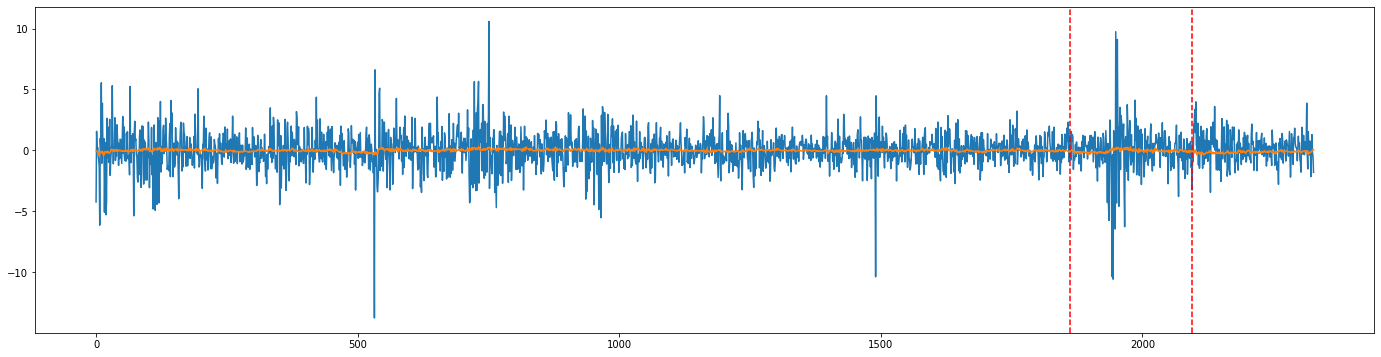

In [213]:
y_true, y_pred = process_predcit(trainer.predict(dataloaders=pl_data.predict_dataloader(), ckpt_path='best'))
plot_preds(y_pred, y_true, splits=(len(pl_data.train_dataset), len(pl_data.train_dataset)+len(pl_data.val_dataset)));

Restoring states from the checkpoint path at lightning_logs/version_31/checkpoints/last.ckpt
Loaded model weights from checkpoint at lightning_logs/version_31/checkpoints/last.ckpt


Predicting: 8it [00:00, ?it/s]

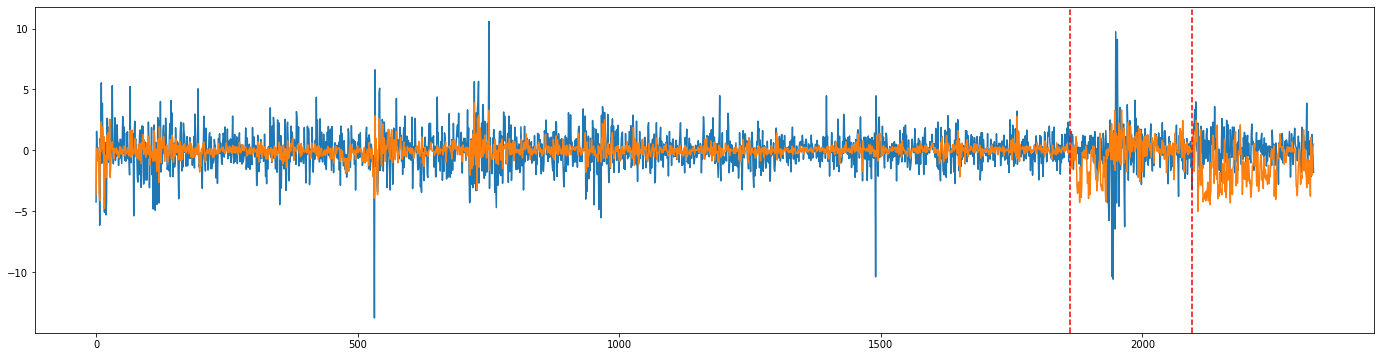

In [214]:
y_true, y_pred = process_predcit(trainer.predict(dataloaders=pl_data.predict_dataloader(), ckpt_path=f'lightning_logs/version_{v}/checkpoints/last.ckpt'))
plot_preds(y_pred, y_true, splits=(len(pl_data.train_dataset), len(pl_data.train_dataset)+len(pl_data.val_dataset)));

In [215]:
logs = read_logs(f'lightning_logs/version_{v}/metrics.csv')

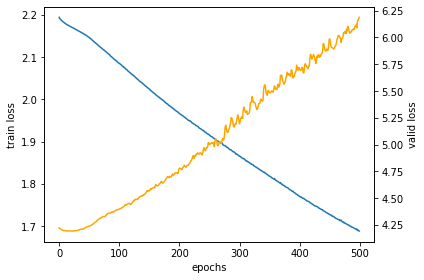

In [216]:
plot_loss(logs['train_loss_epoch'], logs['valid_loss_epoch']);

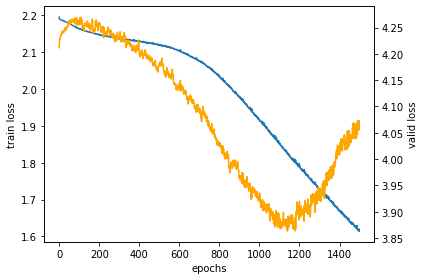

In [140]:
univarialte_fig = plot_loss(logs['train_loss_epoch'], logs['valid_loss_epoch'])
# ~3.863204

## training

In [ ]:
from models import *

In [ ]:
criterion = nn.MSELoss()
# metric = lambda x,y: mse(x,y) # - 1.7788246220526585
metric = mse

In [ ]:
# def auto_accuracy(y_true, y_pred, threshold=0.5):
#     y_true = np.array(y_true, dtype=np.int)
#     y_pred = np.array(y_pred) >= threshold
#     return accuracy(y_true, y_pred)

In [ ]:
# from sklearn.metrics import roc_auc_score

In [ ]:
# criterion = nn.BCELoss()
# metric = auto_accuracy
# # metric = roc_auc_score

In [ ]:
model = VanillaLSTM(
    input_size=config['input_size'],
    output_size=config['output_size'],
    seq_length=config['seq_length'],
    steps=config['steps'],
    
    lstm_layers=1,
    lstm_hidden_size=64,
    bidirectional=True,
    
    fc_layers=None,
    fc_hidden_size=32,
    dropout=0,
)

In [ ]:
model = EncoderDecoderLSTM(
    input_size=config['input_size'], 
    output_size=config['output_size'],
    seq_length=config['seq_length'],
    steps=config['steps'],
    
    encoder_layers=1, 
    encoder_hidden_size=16,
    encoder_bidirectional=False,
    decoder_layers=1, 
    decoder_hidden_size=16,
    decoder_bidirectional=False,
    
    fc_layers=None,
    fc_hidden_size=16,
    dropout=0,
)

In [ ]:
model = DARNN(
    N=config['input_size']-1,
    M=16,
    P=16,
    T=config['seq_length'])

In [ ]:
model = VanillaTransformer(
    input_size=config['input_size'],
    seq_length=config['seq_length'],
    num_layers=1, 
    nhead=config['input_size']
)
# ADD DROPOUT AND OTHER ARGUMENTS

In [ ]:
# trainer = Trainer(model)
# trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.001, weight_decay=0.0001) #0.0001, 0.0001
# # trainer.optimizer = torch.optim.RMSprop(trainer.model.parameters(), lr=0.0001, weight_decay=0.001)
# trainer.scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.99)

In [ ]:
trainer = DARNNTrainer(model, criterion, metric, task=config['task'])
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.001, weight_decay=0.001) #0.001
# trainer.optimizer = torch.optim.RMSprop(trainer.model.parameters(), lr=0.0001, weight_decay=0.001)
trainer.scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=1)

In [ ]:
trainer = TransformerTrainer(model, criterion, metric, task=config['task'])
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.001, weight_decay=0.001) #0.001
# trainer.optimizer = torch.optim.RMSprop(trainer.model.parameters(), lr=0.0001, weight_decay=0.001)
trainer.scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=1)

In [ ]:
trainer = LSTMTrainer(model, criterion, metric, task=config['task'])
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.001, weight_decay=0.001) #0.0001, 0.001 a## 0.0005
# trainer.optimizer = torch.optim.RMSprop(trainer.model.parameters(), lr=0.001, weight_decay=0.0)
trainer.scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=1)

In [ ]:
trainer.fit(train_loader, val_loader, epochs=100, save_logs=False)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
trainer.plot_loss();
# plt.yscale('log')

In [ ]:
np.min(trainer.logs['valid_epoch_metric'])

In [ ]:
trainer.plot('train_step_loss');
# plt.yscale('log')

In [ ]:
trainer.plot('valid_step_loss');
# plt.yscale('log')

In [ ]:
trainer.plot('train_epoch_metric')
trainer.plot('valid_epoch_metric')
# plt.yscale('log')

In [ ]:
baseline_prev = PreviousValueBaseline(task=config['task'])
ret = Trainer(model=baseline_prev).predict(train_loader)
print('previous value:', metric(ret['y_true'], ret['y_pred']))
print('constant zero:', metric(ret['y_true'], np.zeros_like(ret['y_true'])))

In [ ]:
baseline_prev = PreviousValueBaseline(task=config['task'])
ret = Trainer(model=baseline_prev).predict(val_loader)
print('previous value:', metric(ret['y_true'], ret['y_pred']))
print('constant zero:', metric(ret['y_true'], np.zeros_like(ret['y_true'])))

In [ ]:
y_true = ret['y_true']
random_pred = np.random.randint(0,2,size=(1000,len(y_true)))
acc = []
for y_pred in random_pred:
    acc.append(accuracy(y_true, y_pred))

In [ ]:
np.mean(acc)

In [ ]:
# baseline_mean = RollingMeanBaseline(task=config['task'])
# ret = Trainer(model=baseline_mean).predict(val_loader)
# print('rolling mean:', metric(ret['y_true'], ret['y_pred']))

In [ ]:
# baseline_mean = AlwaysOneBaseline()
# ret = Trainer(model=baseline_mean).predict(val_loader)
print('constant one:', accuracy(ret['y_true'], np.ones_like(ret['y_true'])))

In [ ]:
ret = trainer.predict(train_loader)
print('lstm model:', metric(ret['y_true'], ret['y_pred']))

In [ ]:
ret = trainer.predict(val_loader)
print('lstm model:', metric(ret['y_true'], ret['y_pred']))

In [ ]:
ret = trainer.predict(test_loader)
print('lstm model:', metric(ret['y_true'], ret['y_pred']))

In [ ]:
ret = trainer.predict(full_loader)
fig = plot_preds(ret['y_pred'], ret['y_true'], splits=(len(train_dataset), len(train_dataset)+len(val_dataset)))

# shap

In [ ]:
full_val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [ ]:
full_val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
x,y,t=next(iter(full_val_loader))
x = torch.cat((x, y), dim=2)
x.requires_grad_()
baseline = torch.zeros_like(x)

In [ ]:
from captum.attr import (
    IntegratedGradients,
    GradientShap
)

In [ ]:
# integrated = IntegratedGradients(model)
# attr_integrated, delta = integrated.attribute(x, baseline, return_convergence_delta=True)
# attr_integrated = attr_integrated.detach().numpy()

In [ ]:
shap = GradientShap(model)
attr_shap, delta = shap.attribute(x, baseline, return_convergence_delta=True)
attr_shap = attr_shap.detach().numpy()

In [ ]:
feature_names = list(data.columns)
feature_names.append(feature_names.pop(feature_names.index('return_imoex')))

In [ ]:
fig = plt.figure(figsize=(24,8))
plt.bar(x=feature_names, height=attr_shap.mean(axis=(0,1)))

In [ ]:
attr_df = pd.DataFrame(attr_shap.mean(axis=0))
attr_df.columns = feature_names

In [ ]:
pick = [f'close_{i}' for i in ['imoex', 'brn', 'eur', 'usd', 'ftse', 'gld']]# + [f'open_{i}' for i in ['imoex', 'brn', 'eur', 'usd', 'ftse', 'gld']]
# attr_df[pick]

In [ ]:
fig = plt.figure(figsize=(16,10))
plt.plot(attr_shap.mean(axis=0))
plt.legend(feature_names, loc=[1.01, 0])

In [ ]:
fig = plt.figure(figsize=(16,10))
plt.plot(attr_shap[0])
plt.legend(feature_names, loc=[1.01, 0])

In [ ]:
# fig = plt.figure(figsize=(10,4))
# plt.plot(attr_df[pick])
# plt.legend(pick)
# fig.tight_layout()
# # fig.savefig('shap0.pdf', format='pdf', bbox_inches='tight')

In [ ]:
full_loader = DataLoader(full_dataset, batch_size=9999, shuffle=False)
x,y,t=next(iter(full_loader))
x = torch.cat((x, y), dim=2)
x.requires_grad_()
baseline = torch.zeros_like(x)

In [ ]:
attr_shap, delta = shap.attribute(x, baseline, return_convergence_delta=True)
attr_shap = attr_shap.detach().numpy()

In [ ]:
attr_shap.shape

In [ ]:
# attr_lags = attr_shap.squeeze(2)

In [ ]:
attr_df_1 = pd.DataFrame(attr_shap.mean(axis=1))
attr_df_1.columns = feature_names

In [ ]:
attr_df_1.shape

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(data.index[11:], attr_df_1.abs())
# plt.legend(var+list(range(5)), loc=[1.01, 0])
# plt.xticks(data.index[31:])
fig.tight_layout()
# fig.savefig('series.pdf', format='pdf', bbox_inches='tight')
fig.savefig('shap.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(36,6))
plt.plot(data.index[11:], attr_lags)
# plt.legend(pick, loc=[1.01, 0])
# plt.xticks(data.index[31:])
fig.tight_layout()
# fig.savefig('series.pdf', format='pdf', bbox_inches='tight')
# fig.savefig('shap.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(data.index[31:], attr_df_1[pick].abs())
plt.legend(pick, loc=[1.01, 0])
# plt.xticks(data.index[31:])
fig.tight_layout()
# fig.savefig('series.pdf', format='pdf', bbox_inches='tight')
fig.savefig('shap.pdf', format='pdf', bbox_inches='tight')

# optuna

In [ ]:
# dc = DataCollection(data_day, config=config)
# full_dataset, train_dataset, val_dataset, test_dataset = dc.datasets
# full_loader, train_loader, val_loader, test_loader = dc.dataloaders

In [ ]:
def objective(trial):   
    config = {
        'seq_length': 5,
        'steps': 1,
        'batch_size': 256,
        'task': 'regression',
        'target': 'return_imoex',
        'output_size': 1,
        'idx': 'imoex',
        'var': 'return,volume,volatility,spread',
        'add': 'dayofweek',
        
        'lstm_layers': 1,
        'lstm_hidden_size': 64,
        'bidirectional': False,
        'dropout': 0,
        
        'lr': trial.suggest_loguniform('lr', 0.0001, 0.01),
        'weight_decay': trial.suggest_loguniform('weight_decay', 0.0001, 0.01),
        'gamma': 1,
        'epochs': 200,
        }

    dc = DataCollection(data_day, config=config)
    full_dataset, train_dataset, val_dataset, test_dataset = dc.datasets
    full_loader, train_loader, val_loader, test_loader = dc.dataloaders
    
    model = VanillaLSTM(
        input_size=config['input_size'],
        output_size=config['output_size'],
        seq_length=config['seq_length'],
        steps=config['steps'],

        lstm_layers=config['lstm_layers'],
        lstm_hidden_size=config['lstm_hidden_size'],
        bidirectional=config['bidirectional'],
        dropout=config['dropout'],
    )

    trainer = LSTMTrainer(model, criterion=nn.MSELoss(), metric=mse, task=config['task'])
    trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    trainer.scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=config['gamma'])
    
    trainer.fit(train_loader, val_loader, epochs=config['epochs'], verbose=False, save_logs=False)

    # ret = trainer.predict(val_loader)
    print(np.argmin(trainer.logs['valid_epoch_metric']))
    return np.min(trainer.logs['valid_epoch_metric'])
    # return mse(ret['y_true'], ret['y_pred'])

In [ ]:
import optuna
import joblib

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler, direction='minimize')

In [ ]:
study.optimize(objective, n_trials=50)
# joblib.dump(study, 'logs/optuna.pkl')

In [ ]:
# study = joblib.load('logs/optuna.pkl')
df = study.trials_dataframe()
df

In [ ]:
optuna.visualization.plot_contour(study)

# grid search

In [ ]:
class Searcher():
    def __init__(self, train_loader, val_loader, default_model_params={}, default_optimizer_params={}, epochs=50):
        self.epochs = epochs
        self.train_loader, self.val_loader = train_loader, val_loader
        self.default_model_params = default_model_params
        self.default_optimizer_params = default_optimizer_params
    
    def configure_grid(self, grid_dict):
        import itertools
        keys, values = zip(*grid_dict.items())
        return [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    def log(self, res):
        file = 'logs/log_table.txt'
        with open(file, 'a') as f:
            f.write(','.join(res.to_numpy().astype(np.str)))
            f.write('\n')
        
    def trial(self, model_params={}, optimizer_params={}):
        model = VanillaLSTM(
            input_size=config['input_size'], 
            output_size=config['output_size'],
            seq_length=config['seq_length'],
            steps=config['steps'],
            **self.default_model_params,
            **model_params
        )
        trainer = LSTMTrainer(model, criterion=criterion, task=config['task'], metric=metric)
        trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), **self.default_optimizer_params, **optimizer_params) #0.001
        trainer.sceduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=1)

        trainer.fit(self.train_loader, val_loader=None, epochs=self.epochs, save_logs=True)
        ret = trainer.predict(self.val_loader)
        
        res = pd.Series(trainer.model.params)
        res['metric'] = metric(ret['y_true'], ret['y_pred'])
        res['starttime'] = trainer.starttime
        res['idx'] = config['idx']
        return res
    
    def grid_search(self, grid_dict):
        grid = self.configure_grid(grid_dict)
        for d in tqdm(grid):
            res = self.trial(model_params=d)
            print(res)
            self.log(res)

In [ ]:
fun = Searcher(
    train_loader, 
    val_loader, 
    epochs=50, 
    default_model_params=dict(
        fc_layers=None,
        fc_hidden_size=64,
        dropout=0),
    default_optimizer_params=dict(
        lr=0.0001,
        weight_decay=0.001
    )
)

In [ ]:
grid_dict = dict(
        lstm_layers=[1,2], 
        lstm_hidden_size=[2**x for x in range(6,11)],
        bidirectional=[True, False]
    )

fun.grid_search(grid_dict)

# bayesian

In [ ]:
class Wrapper():
    def __init__(self, train_loader, val_loader, default_model_params={}, default_optimizer_params={}, epochs=50):
        self.epochs = epochs
        self.train_loader, self.val_loader = train_loader, val_loader
        self.default_model_params = default_model_params
        self.default_optimizer_params = default_optimizer_params
        
    def __call__(self, params):        
        self.model = VanillaLSTM(
            input_size=config['input_size'], 
            output_size=config['output_size'],
            seq_length=config['seq_length'],
            steps=config['steps'],
            **self.default_model_params,
        )
        self.trainer = LSTMTrainer(self.model, criterion=nn.BCELoss(), task='classification', metric=auto_accuracy)
        self.trainer.optimizer = torch.optim.Adam(self.trainer.model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'], **self.default_optimizer_params) #0.001
        self.trainer.sceduler = torch.optim.lr_scheduler.ExponentialLR(self.trainer.optimizer, gamma=1)

        self.trainer.fit(self.train_loader, val_loader=None, epochs=self.epochs)
        ret = self.trainer.predict(self.val_loader)
        return auto_accuracy(ret['y_true'], ret['y_pred'])

In [ ]:
class Wrapper():
    def __init__(self, model_class, trainer_class, train_loader, val_loader, epochs=50, **kwargs):
        self.epochs = epochs
        self.train_loader, self.val_loader = train_loader, val_loader
        self.model_class = model_class
        self.trainer_class = trainer_class
        
    def __call__(self, kwargs):
        print(kwargs)
        
        self.model = self.model_class(
            input_size=dataset.data.shape[1]+(len(dataset.y_idx) if isinstance(dataset.y_idx, list) else 1), 
            seq_length=config['seq_length'],
            steps=config['steps'],
            fc_layers=None,
            lstm_layers=kwargs['lstm_layers'], 
            lstm_hidden_size=kwargs['lstm_hidden_size'],
            fc_hidden_size=1,
            dropout=0,
            bidirectional=kwargs['bidirectional'])
        self.trainer = self.trainer_class(self.model)
        self.trainer.optimizer = torch.optim.Adam(self.trainer.model.parameters(), lr=kwargs['lr'], weight_decay=kwargs['weight_decay']) #0.001
        self.trainer.sceduler = torch.optim.lr_scheduler.ExponentialLR(self.trainer.optimizer, gamma=1)

        self.trainer.fit(self.train_loader, val_loader=None, epochs=self.epochs)
        ret = self.trainer.predict(self.val_loader)
        return mean_squared_error(ret['y_pred'], ret['y_true'])

In [ ]:
fun = Wrapper(
    train_loader, 
    val_loader, 
    epochs=50, 
    default_model_params=dict(
        lstm_layers=2, 
        lstm_hidden_size=64,
        bidirectional=True,
        fc_layers=None,
        fc_hidden_size=64,
        dropout=0),
    default_optimizer_params=dict()
)

In [ ]:
import hyperopt
from hyperopt import hp

In [ ]:
import hyperopt.pyll
from hyperopt import hp
from hyperopt.pyll import scope

@scope.define
def powerof2(x):
    return int(2**x)

In [ ]:
space = {
    'lr': hp.loguniform('lr', 1e-5, 1e-3)-1,
    'weight_decay': hp.loguniform('weight_decay', 1e-5, 1e-3)-1,
    # 'lstm_layers': hp.randint('lstm_layers', 4)+1,
    # 'lstm_hidden_size': scope.powerof2(hp.randint('lstm_hidden_size', 10)),
    # #'dropout': hp.uniform('dropuot', 0, 0.5),
    # 'bidirectional': hp.choice('bidirectional', [True, False]),
}

In [ ]:
tpe_trials = hyperopt.Trials()
tpe_best = hyperopt.fmin(
    fn=fun, 
    space=space, 
    algo=hyperopt.tpe.suggest, 
    trials=tpe_trials, 
    max_evals=1000
)

In [ ]:
table = pd.DataFrame(tpe_trials.results).join(pd.DataFrame(tpe_trials.idxs_vals[1]))
table['lstm_hidden_size'] = 2**table['lstm_hidden_size']
table['lstm_layers'] = table['lstm_layers']+1

In [ ]:
table.sort_values('loss')

# prediciton

In [ ]:
full_preds, x_attentions, t_attentions = trainer.predict(full_loader)
full_preds = full_preds * np.array(norm_stats)[1][3] + np.array(norm_stats)[0][3]

In [ ]:
ret = trainer.predict(full_loader)

In [ ]:
full_preds = ret['y_pred'] * np.array(norm_stats)[1][3] + np.array(norm_stats)[0][3]
full_true = ret['y_true'] * np.array(norm_stats)[1][3] + np.array(norm_stats)[0][3]

In [ ]:
x_attentions = ret['x_attentions'].mean(1)
t_attentions = ret['t_attentions'].mean(1)

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(data['time_cos'][:1000])
plt.plot(data['time_sin'][:1000])

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(x_attentions[:100])
plt.legend(data.columns)

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(t_attentions[:100])
plt.legend(range(10))

In [ ]:
# data.loc[config['seq_length']:-1, 'predictions'] = full_preds

In [ ]:
# data['return_pred'] = (data['predictions'] - data.shift()['predictions']) / data.shift()['predictions']

In [ ]:
# data['return_pred_vs_actual'] = (data['predictions'] - data.shift()['close_gazp']) / data.shift()['close_gazp']

In [ ]:
fig = plot_preds(full_preds, full_true, splits=(len(train_dataset), len(train_dataset)+len(val_dataset)))
plt.title('Predictions against target, full dataset')

In [ ]:
fig = plot_preds(
    data['return_pred_vs_actual'][config['seq_length']:].to_numpy(), 
    data['return_gazp'][config['seq_length']:].to_numpy(), 
    splits=(len(train_dataset), len(train_dataset)+len(val_dataset)))
plt.title('Predictions against target, full dataset')

In [ ]:
plt.plot((data['return_gazp'] - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5])

In [ ]:
mean_squared_error(
    (data['return_pred_vs_actual'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5], 
    (data['return_gazp'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5]
)

In [ ]:
(data['return_pred_vs_actual'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5]

In [ ]:
fig = plot_preds(data['predictions'][config['seq_length']+1000:1100].to_numpy(), data['close_gazp'][config['seq_length']+1000:1100].to_numpy())
plt.title('Predictions against target, full dataset')

In [ ]:
plt.scatter(
    data['close_gazp'][config['seq_length']:config['seq_length']+len(train_dataset)].to_numpy(), 
    data['predictions'][config['seq_length']:config['seq_length']+len(train_dataset)].to_numpy(),
    color='blue')
plt.scatter(
    data['close_gazp'][config['seq_length']+len(train_dataset):config['seq_length']+len(train_dataset)+len(val_dataset)].to_numpy(), 
    data['predictions'][config['seq_length']+len(train_dataset):config['seq_length']+len(train_dataset)+len(val_dataset)].to_numpy(),
    color='green')
# plt.scatter(
#     data['close'][config['seq_length']+len(train_dataset)+len(val_dataset):].to_numpy(), 
#     data['predictions'][config['seq_length']+len(train_dataset)+len(val_dataset):].to_numpy(),
#     color='red')

In [ ]:
val_preds = trainer.predict(val_loader) * np.array(norm_stats)[1] + np.array(norm_stats)[0]
test_preds = trainer.predict(test_loader) * np.array(norm_stats)[1] + np.array(norm_stats)[0]

In [ ]:
fig = plot_preds(val_preds[:, 4], data['volatility'][len(train_dataset)+config['seq_length']:len(train_dataset)+len(val_dataset)+config['seq_length']].to_numpy())
plt.title('Predictions against target')

In [ ]:
print('Validation')
print('previous item MSE |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], val_dataset.X[SEQ_LENGTH:, 0]))
print('train mean MSE    |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], np.repeat(train_target.mean(), len(val_dataset))))
print('validation MSE    |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], val_preds))

# data

In [95]:
def convert_to_lagged_df(dataset):
    x,y,target = dataset[0]
    num_lags = y.shape[0]
    num_predictors = x.shape[1]
    gen = (np.concatenate([target.numpy(), y.flatten().flip(0).numpy(), x.flip(0).flatten().numpy()]) for (x,y,target) in dataset)
    return pd.DataFrame(gen, columns=['y_target']+[f'y_lag{i+1}' for i in range(num_lags)]+[f'x{j}_lag{i+1}' for i in range(num_lags) for j in range(num_predictors)])

In [96]:
# full_dataset_df = convert_to_lagged_df(dataset)
train_dataset_df = convert_to_lagged_df(train_dataset)
val_dataset_df = convert_to_lagged_df(val_dataset)
test_dataset_df = convert_to_lagged_df(test_dataset)

In [97]:
full_dataset_df = pd.concat([train_dataset_df, val_dataset_df, test_dataset_df]).reset_index(drop=True)
train_val_dataset_df = pd.concat([train_dataset_df, val_dataset_df]).reset_index(drop=True)

In [98]:
train_x, train_target = train_dataset_df.iloc[:, 1:], train_dataset_df.iloc[:, 0]
val_x, val_target = val_dataset_df.iloc[:, 1:], val_dataset_df.iloc[:, 0]
test_x, test_target = test_dataset_df.iloc[:, 1:], test_dataset_df.iloc[:, 0]

In [99]:
full_x, full_target = full_dataset_df.iloc[:, 1:], full_dataset_df.iloc[:, 0]
train_val_x, train_val_target = train_val_dataset_df.iloc[:, 1:], train_val_dataset_df.iloc[:, 0]

# xgb

In [ ]:
import xgboost

In [ ]:
xgb = xgboost.XGBRegressor(max_depth=20, n_estimators=1000)

In [ ]:
xgb.fit(train_x, train_target)

In [ ]:
val_pred = xgb.predict(val_x)

In [ ]:
mean_squared_error(val_target, val_pred)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=100, random_state=1)

In [ ]:
rf.fit(train_x, train_target)

In [ ]:
val_pred = rf.predict(val_x)

In [ ]:
metric(val_pred, val_target)

In [ ]:
plot_preds(val_pred, val_target);

# logreg

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logr = LogisticRegression(max_iter=10000)
logr.fit(train_x, train_target.astype(np.int))
val_pred = logr.predict(val_x)

In [ ]:
accuracy(val_pred, val_target.astype(np.int))

# arima

In [100]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [101]:
result = adfuller(train_val_target)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.584847
p-value: 0.000000


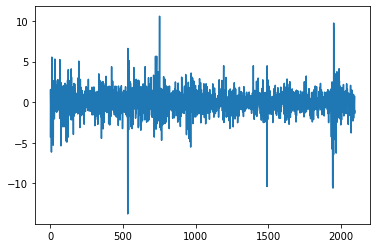

In [102]:
plt.plot(train_val_target)

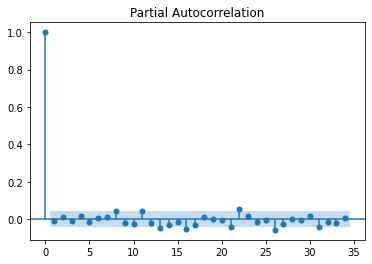

In [103]:
pacf = plot_pacf(train_val_target)

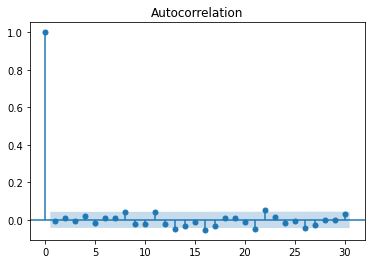

In [104]:
acf = plot_acf(train_val_target, lags=30)

In [ ]:
model = ARIMA(train_target, order=(1,0,7))
model_fit = model.fit()
prediction = model_fit.predict(start=len(train_target), end=len(train_dataset)+len(val_dataset)-1)

In [ ]:
history = [x for x in train_target]
prediction = []

for y_true in val_target:
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    y_pred = model_fit.forecast()[0]
    prediction.append(y_pred)
    history.append(y_true)

In [ ]:
mean_squared_error(val_target, prediction)

In [ ]:
plot_preds(prediction.reset_index(drop=True), val_target);

In [105]:
from pmdarima import auto_arima

In [106]:
stepwise_fit = auto_arima(train_target, start_p=10, start_q=10, max_p=20, max_q=20, 
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(10,0,10)(0,0,0)[0] intercept   : AIC=6763.583, Time=14.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6748.344, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6749.978, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6749.981, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6746.382, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6751.980, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 15.199 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1862
Model:                        SARIMAX   Log Likelihood               -3372.191
Date:                Wed, 04 May 2022   AIC                           6746.382
Time:                        21:15:02   BIC                           6751.911
Sample:                             0   HQIC                          6748.419
                               - 1862                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1907      0.033     66.916      0.000       2.127       2.255
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              4535.33
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
stepwise_fit.predict(start=len(train_target), end=len(train_dataset)+len(val_dataset)-1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])